In [47]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from tqdm import tqdm
from scipy.io import loadmat
from google.colab import drive
import zipfile

In [48]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [49]:
def mount_drive():
    drive.mount('/content/drive')
    return '/content/drive/MyDrive'


In [50]:
def create_dataset_folders(base_path):
    dataset_root = os.path.join(base_path, 'DeepPose_Dataset')
    flic_path = os.path.join(dataset_root, 'FLIC')

    folders = [
        dataset_root,
        flic_path,
        os.path.join(flic_path, 'images'),
        os.path.join(flic_path, 'annotations'),
        os.path.join(dataset_root, 'models'),
        os.path.join(dataset_root, 'results'),
    ]

    for folder in folders:
        os.makedirs(folder, exist_ok=True)

    return flic_path

In [51]:
def extract_flic_dataset(flic_path):
    zip_file = os.path.join(flic_path, 'FLIC.zip')
    images_dir = os.path.join(flic_path, 'images')

    if not os.path.exists(zip_file):
        print(f"ZIP file not found: {zip_file}")
        print("Please download FLIC.zip and examples.mat from https://bensapp.github.io/flic-dataset.html")
        return False

    if os.path.exists(images_dir) and len(os.listdir(images_dir)) > 0:
        print(f"Already extracted: {len(os.listdir(images_dir))} files")
        return True

    print("Extracting FLIC.zip...")
    try:
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            file_list = zip_ref.namelist()
            for file in tqdm(file_list):
                zip_ref.extract(file, images_dir)
        print(f"Extraction complete: {len(file_list)} files")
        return True
    except Exception as e:
        print(f"Extraction failed: {e}")
        return False

In [52]:
def check_directory_structure(base_path):
    print("\n" + "="*70)
    print("Directory Structure")
    print("="*70)

    def print_tree(directory, prefix="", max_depth=3, current_depth=0):
        if current_depth >= max_depth:
            return

        try:
            items = sorted(os.listdir(directory))
        except PermissionError:
            print(f"{prefix}[Permission Denied]")
            return

        dirs = [item for item in items if os.path.isdir(os.path.join(directory, item))]
        files = [item for item in items if os.path.isfile(os.path.join(directory, item))]

        for i, file in enumerate(files):
            is_last = (i == len(files) - 1) and len(dirs) == 0
            connector = "└── " if is_last else "├── "
            file_path = os.path.join(directory, file)
            file_size = os.path.getsize(file_path)

            if file_size > 1024**3:
                size_str = f"{file_size / (1024**3):.2f} GB"
            elif file_size > 1024**2:
                size_str = f"{file_size / (1024**2):.2f} MB"
            elif file_size > 1024:
                size_str = f"{file_size / 1024:.2f} KB"
            else:
                size_str = f"{file_size} B"

            print(f"{prefix}{connector}{file} ({size_str})")

        for i, dir_name in enumerate(dirs):
            is_last = i == len(dirs) - 1
            connector = "└── " if is_last else "├── "
            extension = "    " if is_last else "│   "

            dir_path = os.path.join(directory, dir_name)

            try:
                num_items = len(os.listdir(dir_path))
                print(f"{prefix}{connector}{dir_name}/ ({num_items} items)")
            except:
                print(f"{prefix}{connector}{dir_name}/ [Cannot access]")
                continue

            print_tree(dir_path, prefix + extension, max_depth, current_depth + 1)

    print(f"\nBase Path: {base_path}\n")
    print_tree(base_path)
    print("="*70)

def verify_flic_files(flic_path):
    print("\n" + "="*70)
    print("FLIC Dataset Verification")
    print("="*70)

    mat_file = os.path.join(flic_path, 'examples.mat')
    zip_file = os.path.join(flic_path, 'FLIC.zip')
    images_dir = os.path.join(flic_path, 'images')

    print("\n[Required Files]")

    mat_exists = os.path.exists(mat_file)
    if mat_exists:
        size = os.path.getsize(mat_file)
        size_str = f"{size / (1024**2):.2f} MB" if size > 1024**2 else f"{size / 1024:.2f} KB"
        print(f"  ✓ examples.mat: {size_str}")
    else:
        print(f"  ✗ examples.mat: NOT FOUND")

    if os.path.exists(zip_file):
        size = os.path.getsize(zip_file)
        size_str = f"{size / (1024**3):.2f} GB" if size > 1024**3 else f"{size / (1024**2):.2f} MB"
        print(f"  ✓ FLIC.zip: {size_str}")
    else:
        print(f"  - FLIC.zip: Not found (may be already extracted)")

    print("\n[Images Directory]")
    images_ready = False
    if os.path.exists(images_dir):
        try:
            all_files = os.listdir(images_dir)
            image_files = [f for f in all_files if f.endswith(('.jpg', '.jpeg', '.png', '.bmp'))]

            print(f"  ✓ Total files: {len(all_files)}")
            print(f"  ✓ Image files: {len(image_files)}")

            if len(image_files) > 0:
                sample_img = os.path.join(images_dir, image_files[0])
                print(f"  ✓ Sample: {image_files[0]}")
                images_ready = True
            else:
                print(f"  ⚠ No image files found")
        except Exception as e:
            print(f"  ✗ Error reading directory: {e}")
    else:
        print(f"  ✗ Directory does not exist")

    print("\n" + "="*70)

    dataset_ready = mat_exists and images_ready

    if dataset_ready:
        print("Status: ✓ Dataset is ready")
        print(f"  - Annotation file: Present")
        print(f"  - Images: {len(image_files)} files")
    else:
        print("Status: ✗ Dataset is incomplete")
        if not mat_exists:
            print("  - Missing: examples.mat")
        if not images_ready:
            print("  - Missing: Image files")
        print("\nPlease download from: https://bensapp.github.io/flic-dataset.html")
    print("="*70)

    return dataset_ready

In [53]:
def setup_flic_dataset():
    drive_path = mount_drive()
    flic_path = create_dataset_folders(drive_path)
    extract_flic_dataset(flic_path)
    return flic_path

In [54]:
class HyperParameters:
    def __init__(self):
        self.IMG_SIZE = 220
        self.BATCH_SIZE = 128
        self.NUM_EPOCHS_STAGE1 = 100
        self.NUM_EPOCHS_REFINE = 100
        self.LEARNING_RATE = 0.00005
        self.NUM_JOINTS = 10
        self.NUM_STAGES = 3
        self.SIGMA = 1.0
        self.WEIGHT_DECAY = 1e-5
        self.MOMENTUM = 0.9
        self.DROPOUT = 0.6
        self.GRAD_CLIP = 1.0

    def print_config(self):
        print("\n" + "="*70)
        print("Hyperparameters Configuration")
        print("="*70)
        print(f"Image Size: {self.IMG_SIZE}x{self.IMG_SIZE}")
        print(f"Batch Size: {self.BATCH_SIZE}")
        print(f"Stage 1 Epochs: {self.NUM_EPOCHS_STAGE1}")
        print(f"Refinement Epochs: {self.NUM_EPOCHS_REFINE}")
        print(f"Learning Rate: {self.LEARNING_RATE}")
        print(f"Number of Joints: {self.NUM_JOINTS}")
        print(f"Number of Stages: {self.NUM_STAGES}")
        print(f"Sigma (refinement): {self.SIGMA}")
        print(f"Dropout: {self.DROPOUT}")
        print("="*70)

def print_network_summary(model, input_size=(3, 220, 220)):
    print("\n" + "="*70)
    print("Network Architecture Summary")
    print("="*70)

    try:
        from torchsummary import summary
        summary(model, input_size)
    except:
        print("torchsummary not available, using manual calculation")

        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

        print(f"\nTotal Parameters: {total_params:,}")
        print(f"Trainable Parameters: {trainable_params:,}")
        print(f"Non-trainable Parameters: {total_params - trainable_params:,}")

        print(f"\nModel Size: {total_params * 4 / (1024**2):.2f} MB (float32)")

    print("="*70)

def print_layer_details(model):
    print("\n" + "="*70)
    print("Layer-by-Layer Details")
    print("="*70)

    print(f"{'Layer Name':<40} {'Output Shape':<25} {'Params':<15}")
    print("-"*70)

    total_params = 0
    for name, module in model.named_modules():
        if len(list(module.children())) == 0:
            params = sum(p.numel() for p in module.parameters())
            if params > 0:
                total_params += params
                print(f"{name:<40} {str(params):<25} {params:,}")

    print("-"*70)
    print(f"{'Total':<40} {'':<25} {total_params:,}")
    print("="*70)

In [55]:
class FLICDataset(Dataset):
    def __init__(self, root_dir, is_train=True, transform=None, img_size=220, augment_factor=1):
        self.root_dir = root_dir
        self.is_train = is_train
        self.transform = transform
        self.img_size = img_size
        self.augment_factor = augment_factor if is_train else 1

        mat_path = os.path.join(root_dir, 'examples.mat')

        if not os.path.exists(mat_path):
            raise FileNotFoundError(f"examples.mat not found at {mat_path}")

        mat_data = loadmat(mat_path)
        self.num_joints = 10

        examples = mat_data['examples'][0]

        if is_train:
            self.examples = examples[:3987]
        else:
            self.examples = examples[3987:]

    def __len__(self):
        return len(self.examples) * self.augment_factor

    def __getitem__(self, idx):
        real_idx = idx // self.augment_factor
        aug_idx = idx % self.augment_factor

        example = self.examples[real_idx]

        filepath = example['filepath']
        if isinstance(filepath, np.ndarray):
            filepath = str(filepath[0])
        else:
            filepath = str(filepath)

        img_path = os.path.join(self.root_dir, 'images', filepath)

        if not os.path.exists(img_path):
            raise FileNotFoundError(f"Image not found: {img_path}")

        img = Image.open(img_path).convert('RGB')
        orig_w, orig_h = img.size

        coords = example['coords']

        if coords.ndim == 1:
            coords = coords[0]

        if isinstance(coords, np.ndarray) and coords.shape[0] == 3:
            joints = coords[:2, :].T.copy()
        else:
            joints = coords[:2, :].T.copy() if coords.shape[0] == 3 else coords.T[:, :2].copy()

        valid_mask = ~(np.isnan(joints).any(axis=1))

        if not valid_mask.any():
            joints = np.ones((10, 2)) * 0.5 * np.array([orig_w, orig_h])
        else:
            valid_joints = joints[valid_mask]
            mean_joint = valid_joints.mean(axis=0)

            for i in range(len(joints)):
                if not valid_mask[i]:
                    joints[i] = mean_joint

        torsobox = example['torsobox']
        if torsobox.ndim == 1:
            torsobox = torsobox[0]

        if self.is_train and aug_idx > 0:
            np.random.seed(None)

            if np.random.rand() > 0.5:
                img = img.transpose(Image.FLIP_LEFT_RIGHT)
                joints[:, 0] = orig_w - joints[:, 0]
                joints = joints[[3,4,5,0,1,2,7,6,9,8]]

            scale = np.random.uniform(0.95, 1.05)
            joints = joints * scale

        joints[:, 0] = np.clip(joints[:, 0], 0, orig_w - 1)
        joints[:, 1] = np.clip(joints[:, 1], 0, orig_h - 1)

        if len(joints) >= 10 and valid_mask[0] and valid_mask[7]:
            lsho = joints[0]
            rhip = joints[7]
            torso_diam = np.linalg.norm(lsho - rhip)
        else:
            torso_diam = 100.0

        if torso_diam == 0 or np.isnan(torso_diam) or torso_diam < 10:
            torso_diam = 100.0

        img = img.resize((self.img_size, self.img_size))

        joints[:, 0] = joints[:, 0] * (self.img_size / orig_w)
        joints[:, 1] = joints[:, 1] * (self.img_size / orig_h)

        joints = joints / self.img_size
        joints = np.clip(joints, 0.001, 0.999)

        if np.isnan(joints).any():
            joints = np.nan_to_num(joints, nan=0.5)

        if self.transform:
            img = self.transform(img)

        joints = torch.FloatTensor(joints[:10])
        torso_diam = torch.FloatTensor([max(torso_diam / self.img_size, 0.1)])

        return img, joints, torso_diam

In [56]:
class DeepPoseNetwork(nn.Module):
    def __init__(self, num_joints=10):
        super(DeepPoseNetwork, self).__init__()

        self.num_joints = num_joints

        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self._feature_size = self._get_conv_output((3, 220, 220))

        self.regressor = nn.Sequential(
            nn.Dropout(0.6),
            nn.Linear(self._feature_size, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.6),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_joints * 2),
        )

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def _get_conv_output(self, shape):
        with torch.no_grad():
            input = torch.rand(1, *shape)
            output = self.features(input)
            return int(np.prod(output.size()[1:]))

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.regressor(x)
        x = x.view(-1, self.num_joints, 2)
        return x

In [57]:
class DeepPoseCascade(nn.Module):
    def __init__(self, num_joints=10, num_stages=3, sigma=1.0):
        super(DeepPoseCascade, self).__init__()

        self.num_joints = num_joints
        self.num_stages = num_stages
        self.sigma = sigma

        self.stage1 = DeepPoseNetwork(num_joints)

        self.refinement_stages = nn.ModuleList([
            DeepPoseNetwork(num_joints) for _ in range(num_stages - 1)
        ])

    def forward(self, x, torso_diam=None, return_all_stages=False):
        batch_size = x.size(0)
        img_size = x.size(-1)

        if torso_diam is None:
            torso_diam = torch.ones(batch_size, 1).to(x.device) * 0.45

        all_predictions = []

        y_pred = self.stage1(x)
        all_predictions.append(y_pred)

        for stage_idx, refiner in enumerate(self.refinement_stages):

            y_pred = refiner(x)
            all_predictions.append(y_pred)

        if return_all_stages:
            return all_predictions
        return y_pred

In [58]:
class PoseLoss(nn.Module):
    def __init__(self):
        super(PoseLoss, self).__init__()

    def forward(self, pred_joints, target_joints):
        valid_mask = ~torch.isnan(target_joints)

        if valid_mask.sum() == 0:
            return torch.tensor(0.0, device=pred_joints.device)

        pred_valid = pred_joints[valid_mask]
        target_valid = target_joints[valid_mask]

        loss = torch.sum((pred_valid - target_valid) ** 2)

        return loss / valid_mask.sum()

In [59]:
def calculate_pcp(pred_joints, target_joints, torso_diam, threshold=0.5):
    limbs = [
        (0, 1),
        (1, 2),
        (3, 4),
        (4, 5),
    ]

    correct = 0
    total = 0

    for limb in limbs:
        j1, j2 = limb

        limb_length = torch.norm(target_joints[:, j1] - target_joints[:, j2], dim=1)

        error_j1 = torch.norm(pred_joints[:, j1] - target_joints[:, j1], dim=1)
        error_j2 = torch.norm(pred_joints[:, j2] - target_joints[:, j2], dim=1)

        max_error = torch.max(error_j1, error_j2)
        correct_limb = (max_error <= threshold * limb_length).float()

        correct += correct_limb.sum().item()
        total += pred_joints.size(0)

    return correct / total if total > 0 else 0.0

In [60]:
def calculate_pdj(pred_joints, target_joints, torso_diam, threshold=0.2):
    distances = torch.norm(pred_joints - target_joints, dim=2)

    normalized_distances = distances / torso_diam

    correct = (normalized_distances <= threshold).float()
    pdj = correct.mean().item()

    return pdj

In [61]:
def calculate_pdj_curve(pred_joints, target_joints, torso_diam, thresholds=np.linspace(0, 0.5, 50)):
    pdj_scores = []
    for thresh in thresholds:
        score = calculate_pdj(pred_joints, target_joints, torso_diam, thresh)
        pdj_scores.append(score)
    return pdj_scores

In [62]:
def train_stage(model, train_loader, val_loader, num_epochs=10, learning_rate=0.00005,
                stage_name="Stage1", save_dir=None, resume_from=None):
    print(f"\nTraining {stage_name}")

    criterion = PoseLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5, eps=1e-8)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

    train_losses = []
    val_losses = []
    val_pdj_scores = []

    start_epoch = 0
    best_val_loss = float('inf')

    if resume_from:
        start_epoch, best_val_loss = load_checkpoint(model, optimizer, resume_from)

    patience_counter = 0
    max_patience = 10

    for epoch in range(start_epoch, num_epochs):
        model.train()
        train_loss = 0.0
        valid_batches = 0
        nan_batches = 0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        for batch_idx, (images, joints, torso_diam) in enumerate(pbar):
            try:
                images = images.to(device)
                joints = joints.to(device)
                torso_diam = torso_diam.to(device)

                if torch.isnan(images).any() or torch.isnan(joints).any():
                    nan_batches += 1
                    continue

                optimizer.zero_grad()

                pred_joints = model(images)

                if torch.isnan(pred_joints).any() or torch.isinf(pred_joints).any():
                    nan_batches += 1
                    continue

                loss = criterion(pred_joints, joints)

                if torch.isnan(loss) or torch.isinf(loss) or loss.item() > 100:
                    nan_batches += 1
                    continue

                loss.backward()

                grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)

                has_nan_grad = False
                for param in model.parameters():
                    if param.grad is not None:
                        if torch.isnan(param.grad).any() or torch.isinf(param.grad).any():
                            has_nan_grad = True
                            break

                if has_nan_grad or grad_norm > 100:
                    optimizer.zero_grad()
                    nan_batches += 1
                    continue

                optimizer.step()

                train_loss += loss.item()
                valid_batches += 1
                pbar.set_postfix({
                    'loss': f'{loss.item():.4f}',
                    'grad': f'{grad_norm.item():.2f}',
                    'nan': nan_batches
                })

            except RuntimeError as e:
                print(f"\nRuntime error at batch {batch_idx}: {e}")
                nan_batches += 1
                continue

        if valid_batches == 0:
            print(f"\nNo valid batches in epoch {epoch+1}. Stopping training.")
            break

        train_loss /= valid_batches
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        all_pred_joints = []
        all_target_joints = []
        all_torso_diams = []
        valid_val_batches = 0

        with torch.no_grad():
            for images, joints, torso_diam in val_loader:
                try:
                    images = images.to(device)
                    joints = joints.to(device)
                    torso_diam = torso_diam.to(device)

                    if torch.isnan(images).any() or torch.isnan(joints).any():
                        continue

                    pred_joints = model(images)

                    if torch.isnan(pred_joints).any() or torch.isinf(pred_joints).any():
                        continue

                    loss = criterion(pred_joints, joints)

                    if torch.isnan(loss) or torch.isinf(loss):
                        continue

                    val_loss += loss.item()
                    valid_val_batches += 1

                    all_pred_joints.append(pred_joints.cpu())
                    all_target_joints.append(joints.cpu())
                    all_torso_diams.append(torso_diam.cpu())

                except RuntimeError:
                    continue

        if valid_val_batches == 0:
            print(f"\nNo valid validation batches. Skipping evaluation.")
            continue

        val_loss /= valid_val_batches
        val_losses.append(val_loss)

        scheduler.step(val_loss)

        all_pred_joints = torch.cat(all_pred_joints, dim=0)
        all_target_joints = torch.cat(all_target_joints, dim=0)
        all_torso_diams = torch.cat(all_torso_diams, dim=0)

        all_pred_joints = all_pred_joints * 220
        all_target_joints = all_target_joints * 220
        all_torso_diams = all_torso_diams * 220

        pcp = calculate_pcp(all_pred_joints, all_target_joints, all_torso_diams)
        pdj = calculate_pdj(all_pred_joints, all_target_joints, all_torso_diams)
        val_pdj_scores.append(pdj)

        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f} ({valid_batches}/{len(train_loader)} valid, {nan_batches} skipped)")
        print(f"Val Loss: {val_loss:.4f}")
        print(f"PCP@0.5: {pcp:.4f}")
        print(f"PDJ@0.2: {pdj:.4f}")
        print(f"LR: {optimizer.param_groups[0]['lr']:.6f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0

            if save_dir:
                checkpoint_path = os.path.join(save_dir, f'{stage_name}_best.pth')
                torch.save({
                    'epoch': epoch + 1,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'train_loss': train_loss,
                    'val_loss': val_loss,
                    'pdj': pdj,
                    'pcp': pcp,
                }, checkpoint_path)
                print(f"Saved best checkpoint: {checkpoint_path}")
        else:
            patience_counter += 1

        if save_dir and (epoch + 1) % 10 == 0:
            checkpoint_path = os.path.join(save_dir, f'{stage_name}_epoch_{epoch+1}.pth')
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss,
            }, checkpoint_path)
            print(f"Saved checkpoint: {checkpoint_path}")

        if patience_counter >= max_patience:
            print(f"\nEarly stopping after {epoch+1} epochs")
            break

    return train_losses, val_losses, val_pdj_scores

In [63]:
def visualize_predictions(images, pred_joints, target_joints, num_samples=4):
    fig, axes = plt.subplots(2, num_samples, figsize=(16, 8))

    for i in range(min(num_samples, len(images))):
        img = images[i].cpu().permute(1, 2, 0).numpy()
        img = (img * 0.5 + 0.5).clip(0, 1)

        pred = pred_joints[i].cpu().numpy()
        target = target_joints[i].cpu().numpy()

        axes[0, i].imshow(img)
        axes[0, i].scatter(pred[:, 0], pred[:, 1], c='r', s=50, marker='o')
        axes[0, i].set_title('Predicted')
        axes[0, i].axis('off')

        axes[1, i].imshow(img)
        axes[1, i].scatter(target[:, 0], target[:, 1], c='g', s=50, marker='o')
        axes[1, i].set_title('Ground Truth')
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

In [64]:
def plot_pdj_curve(thresholds, pdj_scores_list, labels):
    plt.figure(figsize=(10, 6))

    for pdj_scores, label in zip(pdj_scores_list, labels):
        plt.plot(thresholds, pdj_scores, marker='o', label=label, linewidth=2)

    plt.xlabel('Normalized Distance to True Joint', fontsize=12)
    plt.ylabel('Detection Rate', fontsize=12)
    plt.title('Percentage of Detected Joints (PDJ)', fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xlim(0, 0.5)
    plt.ylim(0, 1)
    plt.show()

In [66]:
def test_final_model(model, val_loader, num_samples=8, save_dir=None):
    print("\n" + "="*70)
    print("Final Model Testing on Sample Images")
    print("="*70)

    model.eval()

    images, joints, torso_diam = next(iter(val_loader))
    images = images[:num_samples].to(device)
    joints = joints[:num_samples].to(device)
    torso_diam = torso_diam[:num_samples].to(device)

    with torch.no_grad():
        pred_joints = model(images)

    pred_joints_pixel = pred_joints.cpu() * 220
    gt_joints_pixel = joints.cpu() * 220

    fig, axes = plt.subplots(2, num_samples//2, figsize=(20, 10))
    axes = axes.flatten()

    joint_names = ['L-Shoulder', 'L-Elbow', 'L-Wrist', 'R-Shoulder',
                   'R-Elbow', 'R-Wrist', 'L-Hip', 'R-Hip', 'L-Eye', 'R-Eye']

    limbs = [(0, 1), (1, 2), (3, 4), (4, 5), (0, 3), (6, 7), (0, 6), (3, 7)]

    for i in range(num_samples):
        img = images[i].cpu()

        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        img = img * std + mean
        img = torch.clamp(img, 0, 1)
        img = img.permute(1, 2, 0).numpy()

        pred = pred_joints_pixel[i].numpy()
        gt = gt_joints_pixel[i].numpy()

        axes[i].imshow(img)

        for limb in limbs:
            if limb[0] < len(gt) and limb[1] < len(gt):
                axes[i].plot([gt[limb[0], 0], gt[limb[1], 0]],
                            [gt[limb[0], 1], gt[limb[1], 1]],
                            'g-', linewidth=3, alpha=0.7)

        for limb in limbs:
            if limb[0] < len(pred) and limb[1] < len(pred):
                axes[i].plot([pred[limb[0], 0], pred[limb[1], 0]],
                            [pred[limb[0], 1], pred[limb[1], 1]],
                            'r-', linewidth=2)

        axes[i].scatter(gt[:, 0], gt[:, 1], c='green', s=80, marker='o',
                       edgecolors='white', linewidths=2, label='GT', zorder=5)
        axes[i].scatter(pred[:, 0], pred[:, 1], c='red', s=60, marker='x',
                       linewidths=3, label='Pred', zorder=6)

        error = torch.norm(pred_joints_pixel[i] - gt_joints_pixel[i], dim=1).mean()
        axes[i].set_title(f'Sample {i+1} | Avg Error: {error:.1f}px', fontsize=12)
        axes[i].axis('off')

        if i == 0:
            axes[i].legend(loc='upper right', fontsize=10)

    plt.tight_layout()

    if save_dir:
        save_path = os.path.join(save_dir, 'final_test_results.png')
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"\nSaved to: {save_path}")

    plt.show()

    print("\nPer-sample error analysis:")
    for i in range(num_samples):
        error = torch.norm(pred_joints_pixel[i] - gt_joints_pixel[i], dim=1)
        print(f"Sample {i+1}:")
        print(f"  Mean error: {error.mean():.2f}px")
        print(f"  Max error: {error.max():.2f}px")
        print(f"  Min error: {error.min():.2f}px")

    print("="*70)

In [67]:
def load_checkpoint(model, optimizer, checkpoint_path):
    if os.path.exists(checkpoint_path):
        print(f"Loading checkpoint from {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch']
        best_val_loss = checkpoint.get('val_loss', float('inf'))
        print(f"Resuming from epoch {start_epoch}")
        print(f"Best val loss: {best_val_loss:.4f}")
        return start_epoch, best_val_loss
    return 0, float('inf')

In [68]:
def evaluate_single_stage(stage_model, val_loader, stage_name="Stage"):
    """단일 stage 모델 평가"""
    print(f"\nEvaluating {stage_name}...")

    stage_model.eval()
    all_pred = []
    all_target = []
    all_torso = []

    with torch.no_grad():
        for images, joints, torso_diam in tqdm(val_loader, desc=f"Evaluating {stage_name}"):
            images = images.to(device)
            joints = joints.to(device)
            torso_diam = torso_diam.to(device)

            pred_joints = stage_model(images)

            all_pred.append(pred_joints.cpu())
            all_target.append(joints.cpu())
            all_torso.append(torso_diam.cpu())

    all_pred = torch.cat(all_pred, dim=0) * 220
    all_target = torch.cat(all_target, dim=0) * 220
    all_torso = torch.cat(all_torso, dim=0) * 220

    pcp = calculate_pcp(all_pred, all_target, all_torso)
    pdj = calculate_pdj(all_pred, all_target, all_torso)

    print(f"{stage_name} Results:")
    print(f"  PCP@0.5: {pcp:.4f}")
    print(f"  PDJ@0.2: {pdj:.4f}")

    return pcp, pdj

DeepPose: Human Pose Estimation via Deep Neural Networks

Hyperparameters Configuration
Image Size: 220x220
Batch Size: 128
Stage 1 Epochs: 100
Refinement Epochs: 100
Learning Rate: 5e-05
Number of Joints: 10
Number of Stages: 3
Sigma (refinement): 1.0
Dropout: 0.6
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
ZIP file not found: /content/drive/MyDrive/DeepPose_Dataset/FLIC/FLIC.zip
Please download FLIC.zip and examples.mat from https://bensapp.github.io/flic-dataset.html

Directory Structure

Base Path: /content/drive/MyDrive/DeepPose_Dataset

├── FLIC/ (7 items)
│   ├── demo_FLIC.m (676 B)
│   ├── examples.mat (1005.92 KB)
│   ├── lookupPart.m (2.57 KB)
│   ├── myplot.m (404 B)
│   ├── plotbox.m (300 B)
│   ├── annotations/ (0 items)
│   └── images/ (4552 items)
│       ├── 12-oclock-high-special-edition-00006361.jpg (83.47 KB)
│       ├── 12-oclock-high-special-edition-00006371.jpg (84.84 KB)
│       

Evaluating Stage 1: 100%|██████████| 8/8 [00:31<00:00,  3.96s/it]


Stage 1 Results:
  PCP@0.5: 0.1956
  PDJ@0.2: 0.2805
Loaded Stage 2 checkpoint (Epoch 21)

Evaluating Stage 2...


Evaluating Stage 2: 100%|██████████| 8/8 [00:05<00:00,  1.52it/s]


Stage 2 Results:
  PCP@0.5: 0.3201
  PDJ@0.2: 0.4007
Loaded Stage 3 checkpoint (Epoch 33)

Evaluating Stage 3...


Evaluating Stage 3: 100%|██████████| 8/8 [00:05<00:00,  1.50it/s]


Stage 3 Results:
  PCP@0.5: 0.3004
  PDJ@0.2: 0.3807

SUMMARY OF RESULTS
Stage      PCP@0.5         PDJ@0.2        
Stage 1    0.1956          0.2805         
Stage 2    0.3201          0.4007         
Stage 3    0.3004          0.3807         

Saving model...

Testing final model on sample images...
Using Stage 2 (best performance: PDJ@0.2 = 0.4007)

Final Model Testing on Sample Images

Saved to: /content/drive/MyDrive/DeepPose_Dataset/results/final_test_results.png


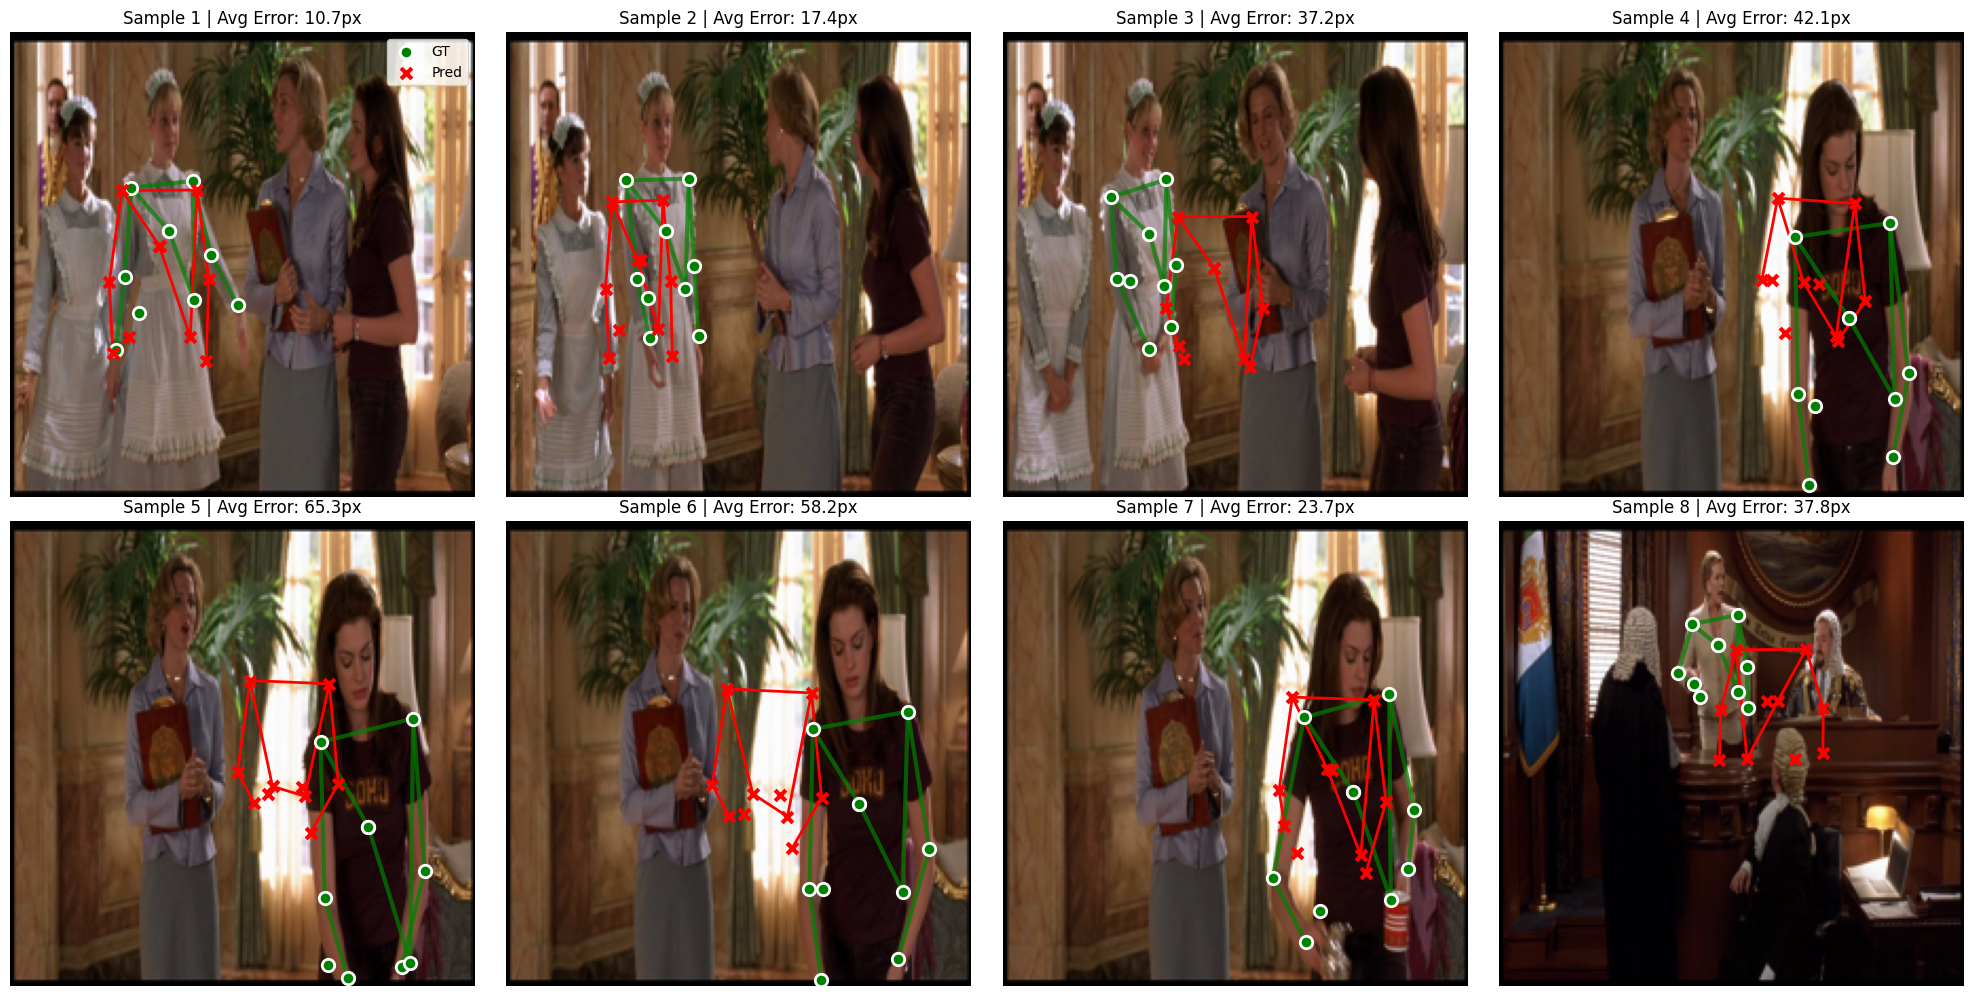


Per-sample error analysis:
Sample 1:
  Mean error: 10.74px
  Max error: 30.40px
  Min error: 1.93px
Sample 2:
  Mean error: 17.36px
  Max error: 22.65px
  Min error: 12.16px
Sample 3:
  Mean error: 37.18px
  Max error: 51.34px
  Min error: 14.22px
Sample 4:
  Mean error: 42.08px
  Max error: 98.59px
  Min error: 19.00px
Sample 5:
  Mean error: 65.27px
  Max error: 93.90px
  Min error: 36.47px
Sample 6:
  Mean error: 58.20px
  Max error: 88.68px
  Min error: 37.86px
Sample 7:
  Mean error: 23.68px
  Max error: 55.67px
  Min error: 7.68px
Sample 8:
  Mean error: 37.80px
  Max error: 64.88px
  Min error: 19.18px

Training completed!


In [69]:
def main():
    print("DeepPose: Human Pose Estimation via Deep Neural Networks")

    hp = HyperParameters()
    hp.print_config()

    flic_path = setup_flic_dataset()

    check_directory_structure(os.path.dirname(flic_path))

    dataset_ready = verify_flic_files(flic_path)

    if not dataset_ready:
        print("\n" + "="*70)
        print("ERROR: Dataset is not ready. Please download required files.")
        print("="*70)
        return

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    print("\nLoading datasets...")

    train_dataset_stage1 = FLICDataset(flic_path, is_train=True,
                                       transform=transform,
                                       img_size=hp.IMG_SIZE,
                                       augment_factor=5)

    train_dataset_refine = FLICDataset(flic_path, is_train=True,
                                       transform=transform,
                                       img_size=hp.IMG_SIZE,
                                       augment_factor=40)

    val_dataset = FLICDataset(flic_path, is_train=False,
                             transform=transform, img_size=hp.IMG_SIZE)

    print(f"Stage 1 Train samples: {len(train_dataset_stage1)}")
    print(f"Refinement Train samples: {len(train_dataset_refine)}")
    print(f"Val samples: {len(val_dataset)}")

    train_loader_stage1 = DataLoader(train_dataset_stage1, batch_size=hp.BATCH_SIZE,
                                     shuffle=True, num_workers=2)
    train_loader_refine = DataLoader(train_dataset_refine, batch_size=hp.BATCH_SIZE,
                                     shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=hp.BATCH_SIZE,
                           shuffle=False, num_workers=2)

    print("\nInitializing DeepPose Cascade...")
    model = DeepPoseCascade(num_joints=hp.NUM_JOINTS,
                           num_stages=hp.NUM_STAGES,
                           sigma=hp.SIGMA).to(device)

    print_network_summary(model.stage1, input_size=(3, hp.IMG_SIZE, hp.IMG_SIZE))
    print_layer_details(model.stage1)

    checkpoint_dir = '/content/drive/MyDrive/DeepPose_Dataset/models/checkpoints'
    os.makedirs(checkpoint_dir, exist_ok=True)

    print("\nSTAGE 1: Initial Pose Estimation")

    resume_checkpoint = os.path.join(checkpoint_dir, 'Stage1_best.pth')

    if os.path.exists(resume_checkpoint):
        print(f"Loading Stage 1 from checkpoint: {resume_checkpoint}")
        checkpoint = torch.load(resume_checkpoint)
        model.stage1.load_state_dict(checkpoint['model_state_dict'])
        print(f"Stage 1 already completed at epoch {checkpoint['epoch']}")
        print(f"Stage 1 PDJ@0.2: {checkpoint.get('pdj', 'N/A'):.4f}")
    else:
        stage1_train_losses, stage1_val_losses, stage1_pdj = train_stage(
            model.stage1, train_loader_stage1, val_loader,
            num_epochs=hp.NUM_EPOCHS_STAGE1,
            learning_rate=hp.LEARNING_RATE,
            stage_name="Stage1",
            save_dir=checkpoint_dir,
            resume_from=None
        )

    for stage_idx in range(hp.NUM_STAGES - 1):
        stage_num = stage_idx + 2
        print(f"\nSTAGE {stage_num}: Refinement")

        best_checkpoint = os.path.join(checkpoint_dir, f'Stage{stage_num}_best.pth')

        # Stage 2 스킵
        if stage_num == 2:
            if os.path.exists(best_checkpoint):
                print(f"Loading Stage 2 from checkpoint: {best_checkpoint}")
                checkpoint = torch.load(best_checkpoint)
                model.refinement_stages[stage_idx].load_state_dict(checkpoint['model_state_dict'])
                print(f"Stage 2 already completed at epoch {checkpoint['epoch']}")
                print(f"Stage 2 PDJ@0.2: {checkpoint.get('pdj', 'N/A'):.4f}")
                continue
            else:
                print("Stage 2 checkpoint not found!")
                continue

        if stage_num == 3:
            if os.path.exists(best_checkpoint):
                checkpoint = torch.load(best_checkpoint)
                completed_epoch = checkpoint['epoch']

                if completed_epoch >= 30:
                    print(f"Loading Stage 3 from checkpoint: {best_checkpoint}")
                    model.refinement_stages[stage_idx].load_state_dict(checkpoint['model_state_dict'])
                    print(f"Stage 3 already completed at epoch {completed_epoch}")
                    print(f"Stage 3 PDJ@0.2: {checkpoint.get('pdj', 'N/A'):.4f}")
                    continue
                else:
                    print(f"Found checkpoint at epoch {completed_epoch}, resuming training...")
                    resume_from = best_checkpoint
            else:
                print(f"No checkpoint found, starting from scratch...")
                resume_from = None
        else:
            if os.path.exists(best_checkpoint):
                print(f"Found checkpoint, resuming training...")
                checkpoint = torch.load(best_checkpoint)
                print(f"Resuming from epoch {checkpoint['epoch']}")
                resume_from = best_checkpoint
            else:
                print(f"No checkpoint found, starting from scratch...")
                resume_from = None

        refine_train_losses, refine_val_losses, refine_pdj = train_stage(
            model.refinement_stages[stage_idx], train_loader_refine, val_loader,
            num_epochs=hp.NUM_EPOCHS_REFINE,
            learning_rate=hp.LEARNING_RATE,
            stage_name=f"Stage{stage_idx + 2}",
            save_dir=checkpoint_dir,
            resume_from=resume_from
        )

    print("\nINDIVIDUAL STAGE EVALUATION")
    print("="*70)

    stage1_checkpoint = os.path.join(checkpoint_dir, 'Stage1_best.pth')
    if os.path.exists(stage1_checkpoint):
        checkpoint = torch.load(stage1_checkpoint)
        model.stage1.load_state_dict(checkpoint['model_state_dict'])
        print(f"Loaded Stage 1 checkpoint (Epoch {checkpoint['epoch']})")
        stage1_pcp, stage1_pdj = evaluate_single_stage(model.stage1, val_loader, "Stage 1")
    else:
        print("Stage 1 checkpoint not found!")
        stage1_pcp, stage1_pdj = 0, 0

    stage2_checkpoint = os.path.join(checkpoint_dir, 'Stage2_best.pth')
    if os.path.exists(stage2_checkpoint):
        checkpoint = torch.load(stage2_checkpoint)
        model.refinement_stages[0].load_state_dict(checkpoint['model_state_dict'])
        print(f"Loaded Stage 2 checkpoint (Epoch {checkpoint['epoch']})")
        stage2_pcp, stage2_pdj = evaluate_single_stage(model.refinement_stages[0], val_loader, "Stage 2")
    else:
        print("Stage 2 checkpoint not found!")
        stage2_pcp, stage2_pdj = 0, 0

    stage3_checkpoint = os.path.join(checkpoint_dir, 'Stage3_best.pth')
    if os.path.exists(stage3_checkpoint):
        checkpoint = torch.load(stage3_checkpoint)
        model.refinement_stages[1].load_state_dict(checkpoint['model_state_dict'])
        print(f"Loaded Stage 3 checkpoint (Epoch {checkpoint['epoch']})")
        stage3_pcp, stage3_pdj = evaluate_single_stage(model.refinement_stages[1], val_loader, "Stage 3")
    else:
        print("Stage 3 checkpoint not found!")
        stage3_pcp, stage3_pdj = 0, 0

    print("\n" + "="*70)
    print("SUMMARY OF RESULTS")
    print("="*70)
    print(f"{'Stage':<10} {'PCP@0.5':<15} {'PDJ@0.2':<15}")
    print(f"Stage 1    {stage1_pcp:<15.4f} {stage1_pdj:<15.4f}")
    print(f"Stage 2    {stage2_pcp:<15.4f} {stage2_pdj:<15.4f}")
    print(f"Stage 3    {stage3_pcp:<15.4f} {stage3_pdj:<15.4f}")
    print("="*70)

    print("\nSaving model...")
    torch.save({
        'model_state_dict': model.state_dict(),
        'num_joints': hp.NUM_JOINTS,
        'num_stages': hp.NUM_STAGES,
        'sigma': hp.SIGMA,
    }, '/content/drive/MyDrive/DeepPose_Dataset/models/deeppose_model.pth')


    print("\nTesting final model on sample images...")
    stage2_checkpoint = os.path.join(checkpoint_dir, 'Stage2_best.pth')
    if os.path.exists(stage2_checkpoint):
        checkpoint = torch.load(stage2_checkpoint)
        model.refinement_stages[0].load_state_dict(checkpoint['model_state_dict'])
        print(f"Using Stage 2 (best performance: PDJ@0.2 = 0.4007)")

    test_final_model(model.refinement_stages[0], val_loader, num_samples=8,
                    save_dir='/content/drive/MyDrive/DeepPose_Dataset/results')

    print("\nTraining completed!")

if __name__ == "__main__":
    main()